REGRESSÃO LINEAR SIMPLES, USANDO TEMPO DE VIAGEM DE LINKS VIZINHOS

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
import statistics
    
import plotnine as p9
import matplotlib.pyplot as plt
import dateutil
import datetime 
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR

from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from yellowbrick.regressor import ResidualsPlot
import statsmodels.formula.api as sm


from sklearn import tree
import math

import warnings
warnings.filterwarnings('ignore')

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


import sys
sys.path.append("../")


In [3]:
with open('../data/linhas.pkl', 'rb') as inputfile:  
    linhas = pickle.load(inputfile)

with open('../data/stops_distances_fixed10.pkl', 'rb') as input_file:
    distancias_pontos = pickle.load(input_file)
    
with open('../data/linesedges.pkl', 'rb') as input_file:
    linesedge = pickle.load(input_file)
    
with open('../data/edgeslines.pkl', 'rb') as input_file:
    edgeslines = pickle.load(input_file)
    
with open('../data/stops_distances.pkl', 'rb') as input_file:
    distancias_paradas = pickle.load(input_file)

In [7]:
for line in range(0,1):    
    linktt = pd.DataFrame(columns=['_id', 'aproxlinkstart', 'hour', 'link', 'ltt', 
                               'month', 'travel_id', 'trip_id', 'weekday'])
    
    for iterated_link in range(0, len(linesedge[linhas[line]])):
    
#     for iterated_link in (range(0, 5)):
        with open('../data/linktt/link-' + str(linesedge[linhas[line]][iterated_link]) + '.pkl', 'rb') as inputfile:  
            linktt_temp = pickle.load(inputfile)  
            linktt = pd.concat([linktt_temp, linktt],sort=False)
  #  start_date = datetime.date(2017, 9, 1)       
   # end_date = datetime.date(2017, 9, 28)  
    linktt['aproxlinkstart'] = pd.to_datetime(linktt['aproxlinkstart'], format = '%H:%M:%S')
    linktt['day'] = pd.to_datetime(linktt['aproxlinkstart'])

    linktt = linktt.loc[(linktt['weekday'] != 1) | (linktt['weekday'] != 7)]

In [8]:
linktt

,_id,aproxlinkstart,hour,link,ltt,month,travel_id,trip_id,weekday,day
0,5c76ed7abd8143570f44e086,2017-01-02 06:15:16.258,6,"(3921, 3922)",26.648044,1,1,2005-10-0,2,2017-01-02 06:15:16.258
1,5c76ed7abd8143570f44e088,2017-01-02 08:45:44.216,8,"(3921, 3922)",6.401308,1,3,2005-10-0,2,2017-01-02 08:45:44.216
2,5c76ed7abd8143570f44e087,2017-01-02 09:57:47.633,9,"(3921, 3922)",26.211229,1,2,2005-10-0,2,2017-01-02 09:57:47.633
3,5c76ed7abd8143570f44e08a,2017-01-02 11:00:25.787,11,"(3921, 3922)",1.198949,1,5,2005-10-0,2,2017-01-02 11:00:25.787
4,5c76ed7abd8143570f44e089,2017-01-02 11:10:58.299,11,"(3921, 3922)",23.441897,1,4,2005-10-0,2,2017-01-02 11:10:58.299
...,...,...,...,...,...,...,...,...,...,...
7643,5c76ed6dbd8143570f3c5c78,2017-09-29 20:13:04.000,20,"(3876, 3877)",85.871241,9,10703,2005-10-0,6,2017-09-29 20:13:04.000
7644,5c76ed6dbd8143570f3c5c79,2017-09-29 20:15:55.000,20,"(3876, 3877)",120.767752,9,10704,2005-10-0,6,2017-09-29 20:15:55.000
7645,5c76ed6dbd8143570f3c5c7a,2017-09-29 20:39:00.000,20,"(3876, 3877)",127.544392,9,10705,2005-10-0,6,2017-09-29 20:39:00.000
7646,5c76ed6dbd8143570f3c5c7b,2017-09-29 21:10:26.000,21,"(3876, 3877)",38.261370,9,10706,2005-10-0,6,2017-09-29 21:10:26.000


In [9]:
linktt['day'] = pd.to_datetime(np.array(linktt['aproxlinkstart'])).day

In [10]:
link = 3

# for link in range(2, len(linesedge[linhas[line]])-3):

linktt_k_neighbor = linktt.loc[((linktt['link'] == str(linesedge[linhas[line]][link-2]))   |
                      (linktt['link'] == str(linesedge[linhas[line]][link - 1])) |
                      (linktt['link'] == str(linesedge[linhas[line]][link]))   |
                      (linktt['link'] == str(linesedge[linhas[line]][link+1])) |
                      (linktt['link'] == str(linesedge[linhas[line]][link+2])) 
                      )]

In [11]:
linktt_k_neighbor

,_id,aproxlinkstart,hour,link,ltt,month,travel_id,trip_id,weekday,day
0,5c76ed6dbd8143570f3d0447,2017-01-02 07:40:55.348,7,"(3881, 3882)",20.830403,1,2,2005-10-0,2,2
1,5c76ed6dbd8143570f3d0448,2017-01-02 08:33:06.512,8,"(3881, 3882)",24.719121,1,3,2005-10-0,2,2
2,5c76ed6dbd8143570f3d0449,2017-01-02 10:31:51.976,10,"(3881, 3882)",22.209721,1,4,2005-10-0,2,2
3,5c76ed6dbd8143570f3d044a,2017-01-02 10:43:00.464,10,"(3881, 3882)",35.423421,1,5,2005-10-0,2,2
4,5c76ed6dbd8143570f3d044b,2017-01-02 11:57:27.121,11,"(3881, 3882)",25.130298,1,6,2005-10-0,2,2
...,...,...,...,...,...,...,...,...,...,...
7652,5c76ed6dbd8143570f3c8665,2017-09-29 20:17:55.767,20,"(3877, 3878)",34.085967,9,10704,2005-10-0,6,29
7653,5c76ed6dbd8143570f3c8663,2017-09-29 20:31:46.700,20,"(3877, 3878)",30.215752,9,10702,2005-10-0,6,29
7654,5c76ed6dbd8143570f3c8666,2017-09-29 20:41:07.544,20,"(3877, 3878)",65.390814,9,10705,2005-10-0,6,29
7655,5c76ed6dbd8143570f3c8667,2017-09-29 21:11:04.261,21,"(3877, 3878)",42.140339,9,10706,2005-10-0,6,29


In [12]:
q1, q3 = np.percentile(linktt_k_neighbor['ltt'],[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
# lower_bound = 10
upper_bound = q3 + (1.5 * iqr)  

frequency = '30min'            
rolling_win = 1

linktt_k_neighbor.index = linktt_k_neighbor['aproxlinkstart']

linktt_k_neighbor = linktt_k_neighbor.loc[(linktt_k_neighbor['ltt'] >= lower_bound) & 
                                          (linktt_k_neighbor['ltt'] <= upper_bound)] 

In [42]:
linktt_k_neighbor['day'] = pd.to_datetime(np.array(linktt_k_neighbor['aproxlinkstart'])).day

df_temp_grouped  = linktt_k_neighbor.groupby([pd.Grouper(freq=str(frequency)), 'link'], as_index=True ).mean()['ltt'].unstack()\
                .rolling(rolling_win).mean().transform(lambda x: x.fillna(method='ffill')).dropna().reset_index()

df_temp_grouped['aproxlinkstart'] = pd.to_datetime(df_temp_grouped['aproxlinkstart'], format = '%H:%M:%S')

df_temp_grouped['aproxlinkstart'].astype('datetime64[M]').astype(int) % 12 + 1

df_temp_grouped['month'] = pd.to_datetime(np.array(df_temp_grouped['aproxlinkstart'])).month
df_temp_grouped['day'] = pd.to_datetime(np.array(df_temp_grouped['aproxlinkstart'])).day
df_temp_grouped['hour'] = pd.to_datetime(np.array(df_temp_grouped['aproxlinkstart'])).hour
df_temp_grouped['minute'] = pd.to_datetime(np.array(df_temp_grouped['aproxlinkstart'])).minute
df_temp_grouped['weekday'] = df_temp_grouped['aproxlinkstart'].dt.strftime('%w')

df_temp_grouped

link,aproxlinkstart,"(3877, 3878)","(3878, 3879)","(3879, 3880)","(3880, 3881)","(3881, 3882)",month,day,hour,minute,weekday
0,2017-01-02 08:30:00,84.882808,43.850302,110.100705,75.689786,24.719121,1,2,8,30,1
1,2017-01-02 10:00:00,34.731703,31.516945,110.100705,75.689786,24.719121,1,2,10,0,1
2,2017-01-02 10:30:00,115.872462,22.481070,17.112842,28.116379,28.816571,1,2,10,30,1
3,2017-01-02 11:30:00,116.602078,41.550111,68.783454,28.197987,25.130298,1,2,11,30,1
4,2017-01-02 12:30:00,35.477288,37.677026,104.571621,53.621040,47.567669,1,2,12,30,1
...,...,...,...,...,...,...,...,...,...,...,...
4765,2017-09-29 17:30:00,77.950697,46.228697,103.462928,69.138271,48.756736,9,29,17,30,5
4766,2017-09-29 20:00:00,48.994428,74.152934,23.968640,17.159609,12.279942,9,29,20,0,5
4767,2017-09-29 20:30:00,47.803283,35.852847,55.352859,48.166790,55.392468,9,29,20,30,5
4768,2017-09-29 21:00:00,42.140339,64.584359,24.327076,41.382969,30.492734,9,29,21,0,5


In [14]:
#def regressao_linear_links_vizinhos():
    #month, hour, minute = datetime.fromtimestamp(month, hour, minute)
    
df = df_temp_grouped.loc[(df_temp_grouped['month']==1) & (df_temp_grouped['hour']==8) & (df_temp_grouped['minute']==30)]
df = df.reset_index()
    
x = df.iloc[:, 2:6].values
y = df.iloc[:, 6].values


In [15]:
df

link,index,aproxlinkstart,"(3877, 3878)","(3878, 3879)","(3879, 3880)","(3880, 3881)","(3881, 3882)",month,day,hour,minute,weekday
0,0,2017-01-02 08:30:00,84.882808,43.850302,110.100705,75.689786,24.719121,1,2,8,30,1
1,23,2017-01-03 08:30:00,73.417720,23.165477,84.434301,39.256337,29.898410,1,3,8,30,2
2,51,2017-01-04 08:30:00,65.131053,30.196161,94.777212,51.451726,38.042086,1,4,8,30,3
3,79,2017-01-05 08:30:00,67.045932,14.637876,42.415678,18.199322,17.651652,1,5,8,30,4
4,98,2017-01-06 08:30:00,45.424210,36.217417,96.977551,54.290363,22.709287,1,6,8,30,5
5,125,2017-01-09 08:30:00,43.866934,41.213826,64.610210,50.734223,49.019627,1,9,8,30,1
6,150,2017-01-10 08:30:00,65.974403,25.503181,24.428189,38.497817,65.720437,1,10,8,30,2
7,181,2017-01-11 08:30:00,90.620490,25.886635,71.338768,50.245637,95.077883,1,11,8,30,3
8,207,2017-01-12 08:30:00,92.841295,27.639313,87.650625,52.757666,63.917229,1,12,8,30,4
9,231,2017-01-13 08:30:00,73.163850,30.359863,84.799804,62.967369,67.773544,1,13,8,30,5


In [16]:
modelo = LinearRegression()
modelo.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
modelo.score(x, y)

0.36980997998381815

In [18]:
previsoes = modelo.predict(x)
    
MAPE = []

In [19]:
for i in range(len(y)):
        MAPE.append(mean_absolute_percentage_error(y[i], previsoes[i]))

In [20]:
previsoes_dt = pd.DataFrame(previsoes)
previsoes_dt

,0
0,71.761715
1,36.955912
2,43.330974
3,22.997933
4,39.466282
5,44.018437
6,44.323336
7,54.998530
8,55.739713
9,56.243019


In [21]:
df['(3881, 3882)']

0     24.719121
1     29.898410
2     38.042086
3     17.651652
4     22.709287
5     49.019627
6     65.720437
7     95.077883
8     63.917229
9     67.773544
10    70.249905
11    33.760408
12    13.521942
13    32.169338
14    38.746980
15    46.273783
16    30.371190
17    42.339339
18    16.181937
19    23.233519
20    62.965300
Name: (3881, 3882), dtype: float64

In [22]:
MAPE

[190.30852220991264,
 23.60494068834309,
 13.902727789881839,
 30.28770877718235,
 73.78917403315096,
 10.2024235020097,
 32.55775812879943,
 42.15423348181213,
 12.79391412084568,
 17.01331220381595,
 10.934895678792321,
 34.51648218925062,
 99.6834642584395,
 38.12601400886378,
 1.9746961085294532,
 22.55519741368095,
 20.08057803569397,
 14.693264748960901,
 49.83449276637377,
 48.5656462127655,
 17.897651370885775]

In [23]:
mape=pd.DataFrame(MAPE)
mape

,0
0,190.308522
1,23.604941
2,13.902728
3,30.287709
4,73.789174
5,10.202424
6,32.557758
7,42.154233
8,12.793914
9,17.013312


In [24]:
lista_ = []
for i in range(len(y)):
    lista_.append(df.iloc[i, 6])   

In [25]:
#media de tempo em segundos do link(3877, 3878) no mês de janeiro, do dia 2 ao dia 30
np.mean(lista_)

42.11156743111333

In [26]:
#variancia em relação à media
np.var(lista_)

447.3985464078115

In [27]:
#desvio para mais ou para menos de 21 segundos
np.std(lista_)

21.15179771101765

In [37]:
linktt_k_neighbor['time_stamp_start'] = [d.timestamp() for d in linktt_k_neighbor['aproxlinkstart']]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f17a4222b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f17a40f6748>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f17a45370b8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f17a4163e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f17a40b4908>],
 'means': []}

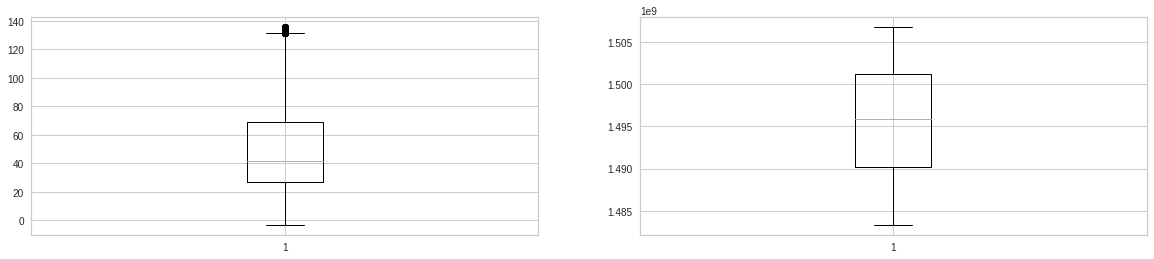

In [38]:
f, axarr = plt.subplots(1, 2, figsize=(20, 4))
axarr[0].boxplot(linktt_k_neighbor["ltt"], showfliers=True)
axarr[1].boxplot(linktt_k_neighbor["time_stamp_start"], showfliers=True)